In [167]:
import datetime as dt
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import datetime as dt
import pmdarima
import matplotlib.pyplot as plt
from datetime import datetime
from arch import arch_model

In [168]:
def getData():
    """
    Random walk model simply needs to predict the open price from previous timestep with some random noise
    params: arr (NumPy array)
    returns: output (Numpy array of size 1 x 5)
    """
    output = np.load("data\\tensor.npy")
    return output[:,562:,:]

data = getData()

In [169]:
apple_adj = web.DataReader('AAPL', 'yahoo', start='1999-11-26', end='2019-10-23')["Adj Close"]
amzn_adj = web.DataReader('AMZN', 'yahoo', start='1999-11-26', end='2019-10-23')["Adj Close"]
msft_adj = web.DataReader('MSFT', 'yahoo', start='1999-11-26', end='2019-10-23')["Adj Close"]

apple_returns = 100 * apple_adj.pct_change().dropna()
amzn_returns = 100 * amzn_adj.pct_change().dropna()
msft_returns = 100 * msft_adj.pct_change().dropna()

In [188]:
y_train = apple_returns.to_numpy()[:-20]
y_test = apple_returns.to_numpy()[-20:]
x_train = getData()[0][:-20]
x_test = getData()[0][-20:]

In [189]:
# fit ARIMA on Apple returns
arima = pmdarima.auto_arima(y_train, x_train)
p, d, q = arima.order
arima_residuals = arima.arima_res_.resid

# fit GARCH(1, 1) model on ARIMA residuals
garch = arch.arch_model(y=arima_residuals, vol="Garch", p=1, q=1, dist="t")
garch_fitted = garch.fit()

# predicted_mu
predicted_mu = arima.predict(n_periods=20, X=x_test)

# predicted residual
garch_forecast = garch_fitted.forecast(horizon=20, reindex=True)
predicted_et = garch_forecast.mean.iloc[-1].to_numpy()

# yhat
yhat = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      7,   Neg. LLF: 40304.171804678874
Iteration:      2,   Func. Count:     16,   Neg. LLF: 21772.195067432996
Iteration:      3,   Func. Count:     25,   Neg. LLF: 15232.258883207736
Iteration:      4,   Func. Count:     32,   Neg. LLF: 10681.612147187723
Iteration:      5,   Func. Count:     38,   Neg. LLF: 18832.711028843554
Iteration:      6,   Func. Count:     46,   Neg. LLF: 14844.978621820641
Iteration:      7,   Func. Count:     54,   Neg. LLF: 10677.461724006871
Iteration:      8,   Func. Count:     61,   Neg. LLF: 11984.789044337533
Iteration:      9,   Func. Count:     70,   Neg. LLF: 13327.737962660402
Iteration:     10,   Func. Count:     77,   Neg. LLF: 10671.823473194629
Iteration:     11,   Func. Count:     83,   Neg. LLF: 10671.809874710885
Iteration:     12,   Func. Count:     89,   Neg. LLF: 10671.808454178548
Iteration:     13,   Func. Count:     95,   Neg. LLF: 10671.80842733035
Iteration:     14,   Func. Count:    101,   Neg. LLF

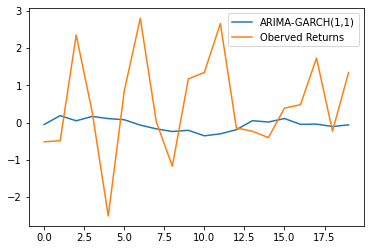

In [186]:
plt.plot(yhat, label="ARIMA-GARCH(1,1)")
plt.plot(y_test, label="Oberved Returns")
plt.legend()
plt.show()

In [190]:
def mae(yhat, y):
    residuals =  [abs(pair[1] - pair[0]) for pair in zip(yhat, y)]
    return sum(residuals) / len(residuals)

mae(yhat, y_test)

1.0917823433342349